## Image classification using Food-101 dataset

### Task description
1. Grab the dataset from https://huggingface.co/datasets/food101
2. Implement a convolutional neural network for multiclass image classification.
3. Use https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html or `dl_lab5` for inspiration.

In [39]:
import torch
import numpy as np
import torchvision 
from torchvision import transforms 
import pyarrow.parquet as pq
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from IPython.display import display

### Reading Data

In [57]:
def read_parquet(file):
    desired_size = (28, 28)
    table = pq.read_table(file)
    image_bytes = table.column('image').to_pylist()
    labels_in = table.column('label').to_pylist()

    transform = transforms.Compose([
        transforms.Resize(desired_size),
        transforms.ToTensor()
    ])

    images = []
    labels = []
    for i,img_bytes in enumerate(image_bytes):
        image = Image.open(io.BytesIO(img_bytes['bytes']))
        image = transform(image)
        if image.size() == torch.Size([3, 28, 28]):
            labels.append(labels_in[i])
            images.append(image)
    train_labels = torch.tensor(labels)
    train_images = torch.stack(images)
    return TensorDataset(train_images, train_labels)
    

In [3]:
for i in range(8):
    if i == 0:
        train_dataset = read_parquet(f"train-0000{i}-of-00008.parquet")
    else:
        train_dataset += read_parquet(f"train-0000{i}-of-00008.parquet")

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
for i in range(3):
    if i == 0:
        test_dataset = read_parquet(f"validation-0000{i}-of-00003.parquet")
    else:
        test_dataset += read_parquet(f"validation-0000{i}-of-00003.parquet")

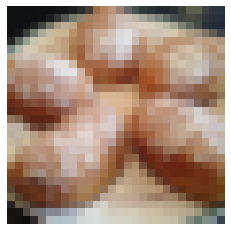

In [6]:
import matplotlib.pyplot as plt
import numpy as np
img_tensor = train_dataset[29][0]
img_np = img_tensor.numpy().transpose(1, 2, 0)
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [7]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(test_dataset, batch_size, shuffle=False)

### Model

In [8]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 3, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [9]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 3, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [10]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 101)) 

In [11]:
#device = torch.device("mps")
device = torch.device("cpu")

model = model.to(device) 

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.0517 val_accuracy: 0.0929
Epoch 2 accuracy: 0.0908 val_accuracy: 0.1152
Epoch 3 accuracy: 0.1152 val_accuracy: 0.1411
Epoch 4 accuracy: 0.1344 val_accuracy: 0.1577
Epoch 5 accuracy: 0.1501 val_accuracy: 0.1641
Epoch 6 accuracy: 0.1641 val_accuracy: 0.1755
Epoch 7 accuracy: 0.1725 val_accuracy: 0.1787
Epoch 8 accuracy: 0.1841 val_accuracy: 0.1807
Epoch 9 accuracy: 0.1945 val_accuracy: 0.1822
Epoch 10 accuracy: 0.2047 val_accuracy: 0.1770


### Results

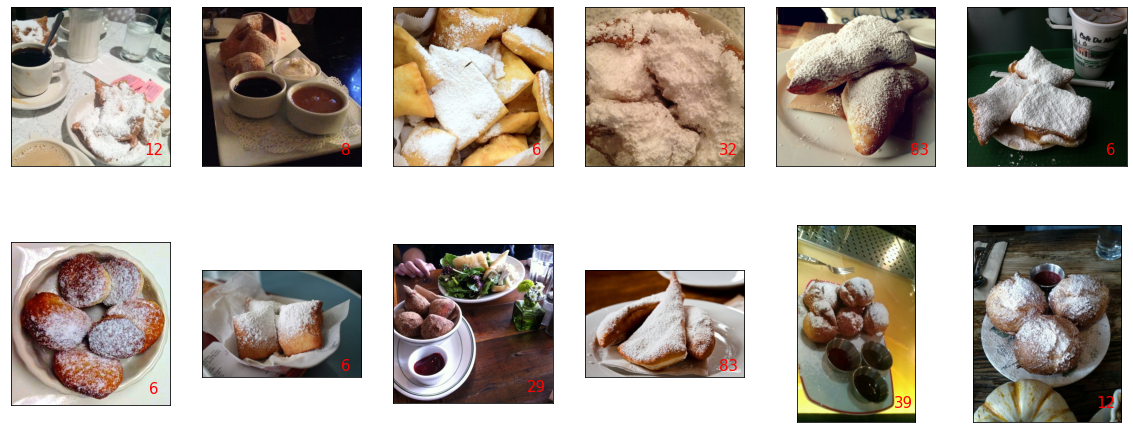

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
table = pq.read_table("validation-00000-of-00003.parquet")
image_bytes = table.column('image').to_pylist()
labels_in = table.column('label').to_pylist()

transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

fig = plt.figure(figsize=(20, 8))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img_bytes = image_bytes[i]
    img = Image.open(io.BytesIO(img_bytes['bytes']))
    img = transform(img)
    pred = model(img.unsqueeze(0))
    y_pred = torch.argmax(pred)
    
    img = Image.open(io.BytesIO(img_bytes['bytes']))
    ax.imshow(img)  
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
#plt.savefig('figures/14_14.png')
plt.show()
    


In [54]:
labels_in[:12]

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Бачимо, що наша модель вгадал 4/12 картинок, що є непоганим результатом враховуючи що є аж 101 варіант вибору